In [93]:
# Pre-processing
import collections
import numpy as np
import pandas as pd
import math

# General visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Geospatial visualization
import geopandas as gpd
import shapely
from shapely.geometry import Point
from geopy.geocoders import GoogleV3
from scipy import ndimage

# data processing for modeling
from sklearn.utils import shuffle
import datetime
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# modeling
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

# data evaluation
from sklearn.metrics import confusion_matrix

In [6]:
# Display otpions
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 100)
np.set_printoptions(linewidth=100)

In [7]:
# 10 primary (more important) tables
primaryTables = [
    'nibrs_arrestee', 'nibrs_bias_motivation', 'nibrs_incident', 'nibrs_offender', 'nibrs_offense',
    'nibrs_property_desc', 'nibrs_property', 'nibrs_victim_injury', 'nibrs_victim_offender_rel', 'nibrs_victim'
]

# 24 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    'nibrs_activity_type': ('activity_type_id', 'activity_type_name'),
    'nibrs_age': ('age_id', 'age_name'),
    'nibrs_arrest_type': ('arrest_type_id', 'arrest_type_name'), 
    'nibrs_assignment_type': ('assignment_type_id', 'assignment_type_name'),
    'nibrs_bias_list': ('bias_id', 'bias_name'),
    'nibrs_circumstances': ('circumstances_id', 'circumstances_name'),
    'nibrs_cleared_except': ('cleared_except_id', 'cleared_except_name'),
    'nibrs_criminal_act_type': ('criminal_act_id', 'criminal_act_name'),
    'nibrs_drug_measure_type': ('drug_measure_type_id', 'drug_measure_name'),
    'nibrs_ethnicity': ('ethnicity_id', 'ethnicity_name'),
    'nibrs_injury': ('injury_id', 'injury_name'),
    'nibrs_justifiable_force': ('justifiable_force_id', 'justifiable_force_name'),
    'nibrs_location_type': ('location_id', 'location_name'),
    'nibrs_month': ('nibrs_month_id', 'month_num'),
    'nibrs_offense_type' : ('offense_type_id', 'offense_name'),
    'nibrs_prop_desc_type': ('prop_desc_id', 'prop_desc_name'),
    'nibrs_prop_loss_type': ('prop_loss_id', 'prop_loss_name'),
    'nibrs_relationship': ('relationship_id', 'relationship_name'),
    'nibrs_suspected_drug_type': ('suspected_drug_type_id', 'suspected_drug_name'),
    'nibrs_using_list': ('suspect_using_id', 'suspect_using_name'),
    'nibrs_victim_type': ('victim_type_id', 'victim_type_name'),
    'nibrs_weapon_type': ('weapon_id', 'weapon_name'),
    'ref_race': ('race_id', 'race_desc'),
    'ref_state': ('state_id', 'state_name')
}

# 9 secondary (less important) tables
secondaryTables = [
    'agency_participation', 'cde_agencies', 'nibrs_arrestee_weapon', 'nibrs_criminal_act', 'nibrs_suspected_drug',
    'nibrs_suspect_using', 'nibrs_victim_circumstances', 'nibrs_victim_offense', 'nibrs_weapon'
]

In [8]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., PA-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

# PA2016 = readCSVs('PA-2016')

In [9]:
# Replace a col with a specified mapping dict:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(SC2016)
# maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 24 lookup tables


In [10]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        oldCol, newCol = lookupTables[lookupTableName]
        # dic: the nested dictionary required by df.replace()
        dic = {oldCol: maps[(oldCol, newCol)]}
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)



## Model: Predict Offender's Features

With information of these dataframes, we would like to predict the features of the offender (sex, age, race, relationship with the victim, offense motivation, etc.) given information of the incident (date, time, offense type, etc.) and victim (age, sex, race, injury).

### Data collection and processing

In order to build a robust model, we need a larger dataset than PA2016. In this project we used South California dataset (SC2016) which is 5 times larger.

In [79]:
SC2016 = readCSVs('SC-2016')
print('Replacing and Renaming columns...')
replaceAndRename(SC2016['nibrs_incident'], ['nibrs_month'])
replaceAndRename(SC2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(SC2016['nibrs_offender'], ['ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_arrestee'], ['nibrs_offense_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_victim'], ['nibrs_victim_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(SC2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
replaceAndRename(SC2016['nibrs_property'], ['nibrs_prop_loss_type'])
replaceAndRename(SC2016['nibrs_property_desc'], ['nibrs_prop_desc_type'])
print('Done')

Reading all CSVs for SC-2016 dataset...
Finished reading 43 CSVs
Replacing and Renaming columns...
Done


Next we will create a dataframe containing all the columns with meaningful information associated with incident, victim, offender and offense.

We selected the following features as input:
 - **victim age** (int)
 - **victim sex** (M, F, U)
 - **victim race** (Unknown, White, Black or African American, American Indian or Alaska Native, Asian, Asian, Native Hawaiian, or Other Pacific Islander, Chinese, Japanese, Native Hawaiian or Other Pacific Islander, Other, Multiple, Not Specified)
 - **victim ethnicity** (Not Hispanic or Latino, Unknown, Hispanic or Latino)
 - **victim resident status** (R, nan, N, U)
 - **victim type** (Business, Financial Institution, Government, Individual, Law Enforcement Officer, Other, Religious, Organization, Society/Public, Unknown)
 - **victim sequence number** (int)
 - **time of the incident** (datetime)
 - **type of injury** (Apparent Broken Bones, Possible Internal Injury, Severe Laceration, Minor Injury, None, Other Major Injury, Loss of Teeth, Unconscious)
 - **offense type** (Not Specified, Justifiable Homicide, False Pretenses/Swindle/Confidence Game, Statutory Rape, Sexual Assault With An Object, Destruction/Damage/Vandalism of Property, Family Offenses, Nonviolent, Theft of Motor Vehicle Parts or Accessories, Pornography/Obscene Material, Sports Tampering, Driving Under the Influence, Counterfeiting/Forgery, Welfare Fraud, Pocket-picking, Theft From Motor Vehicle, Assisting or Promoting Prostitution, Drug/Narcotic Violations, Wire Fraud, Purse-snatching, Runaway, Arson, Motor Vehicle Theft, Drunkenness, Shoplifting, Operating/Promoting/Assisting Gambling, Bad Checks, Extortion/Blackmail, Aggravated Assault, Stolen Property Offenses, Kidnapping/Abduction, Prostitution, Betting/Wagering, Murder and Nonnegligent Manslaughter, Peeping Tom, Trespass of Real Property, Drug Equipment Violations, Rape, Embezzlement, Negligent Manslaughter, Weapon Law Violations, Robbery, Credit Card/Automated Teller Machine Fraud, Curfew/Loitering/Vagrancy Violations, Sodomy, Intimidation, All Other Larceny, Impersonation, Theft From Building, All Other Offenses, Burglary/Breaking & Entering, Theft From Coin-Operated Machine or Device, Simple Assault, Liquor Law Violations, Disorderly Conduct, Gambling Equipment Violation, Incest, Fondling, Bribery, Human Trafficking, Commercial Sex Acts, Human Trafficking, Involuntary Servitude, Purchasing Prostitution, Identity Theft, Hacking/Computer Invasion, Animal Cruelty)
 
And selected the following features as prediction output:
age (int)
 - offender age (int)
 - offender sex (M, F, U)
 - offender race (Unknown, White, Black or African American, American Indian or Alaska Native, Asian, Asian, Native Hawaiian, or Other Pacific Islander, Chinese, Japanese, Native Hawaiian or Other Pacific Islander, Other, Multiple, Not Specified)
 - offender ethnicity (Not Hispanic or Latino, Unknown, Hispanic or Latino)
 - relationship (Victim Was Acquaintance, Victim Was Babysittee, Victim Was Boyfriend/Girlfriend, Victim Was Child of Boyfriend or Girlfriend, Victim Was Child, Victim Was Common-Law Spouse, Victim was Employee, Victim was Employer, Victim Was Friend, Victim Was Grandchild, Victim Was Grandparent, Homosexual Relationship, Victim Was In-law, Victim Was Neighbor, Victim Was Other Family Member, Victim was Otherwise Known, Victim Was Parent, Relationship Unknown, Victim Was Sibling, Victim Was Stepchild, Victim Was Spouse, Victim Was Stepparent, Victim Was Stepsibling, Victim Was Stranger, Victim Was Offender, Victim was Ex-Spouse)
 - bias type (Anti-Native Hawaiian or Other Pacific Islander, Anti-Physical Disability, Anti-Mental Disability, Anti-Male, Anti-Female, Anti-Transgender, Anti-Gender Non-Conforming, Anti-White, Anti-Black or African American, Anti-American Indian or Alaska Native, Anti-Asian, Anti-Multi-Racial Group, Anti-Jewish, Anti-Catholic, Anti-Protestant, Anti-Islamic (Muslem), Anti-Other Religion, Anti-Multi-Religious Group, Anti-Atheist/Agnosticism, Anti-Arab, Anti-Hispanic or Latino, Anti-Not Hispanic or Latino, Anti-Male Homosexual (Gay), Anti-Female Homosexual (Lesbian), Anti-Lesbian, Gay, Bisexual, or Transgender, Mixed Group (LGBT), Anti-Heterosexual, Anti-Bisexual, None, Unknown, Anti-Mormon, Anti-Jehovah's Witness, Anti-Eastern Orthodox, Anti-Other Christian, Anti-Buddhist, Anti-Hindu, Anti-Sikh)

In [80]:
def formalizePersonalInfo(rawDF, identity):
    """
    Select valid ages and rename some columns of the dataframe containin personal information
    Args:
        rawDF (DataFrame): DataFrame to be formalized
        df (DataFrame): Formalized dataframe
    """
    return rawDF[rawDF['age_id'] == 5.0].drop('age_id', axis=1)\
.rename(columns={"age_num": identity + "_age","sex_code": identity + "_sex", "race_desc": identity + "_race", \
                "ethnicity_name": identity + "_ethnicity", "resident_status_code": identity + "_resident_status"})

# First select the data frame with victim_id and offender_id, and merge other dataframes into it by matching victim_id.
dataframe = formalizePersonalInfo(SC2016["nibrs_victim_offender_rel"].merge(SC2016['nibrs_victim'], how='left', on='victim_id')\
                                  .merge(SC2016['nibrs_incident'], how='left', on='incident_id')\
                                  [['victim_id', 'offender_id', 'incident_id', 'relationship_name',\
                                    'victim_seq_num', 'victim_type_name','age_id', 'age_num', 'sex_code','month_num', \
                                    'race_desc', 'ethnicity_name', 'resident_status_code', 'incident_date']], 'victim')

# Continue to merge dataframes to diversify the information.
dataframe = formalizePersonalInfo(dataframe.merge(SC2016['nibrs_victim_injury'], how = 'left', on = 'victim_id')
                                  .merge(SC2016['nibrs_injury'], how = 'left', on = 'injury_id')\
                                  .drop(['injury_id', 'injury_code'], axis=1)\
                                  .merge(SC2016['nibrs_offender'], how = 'left',\
                                         on = ['incident_id', 'offender_id'])\
                                  .drop(['ff_line_number', 'age_range_low_num', 'age_range_high_num'], axis = 1)\
                                  .merge(SC2016['nibrs_offense'], how = 'left', on = 'incident_id')\
                                  .drop(['attempt_complete_flag', 'location_name', 'num_premises_entered',\
                                         'method_entry_code', 'ff_line_number'], axis=1)\
                                  .merge(SC2016['nibrs_bias_motivation'], how = 'left', on = 'offense_id')\
                                  .merge(SC2016['nibrs_bias_list'], how = 'left', on = 'bias_id')\
                                  .drop(['victim_id', 'offender_id', 'incident_id', 'offense_id', 'bias_id',\
                                         'bias_code'], axis=1), 'offender')

dataframe.tail()

,relationship_name,victim_seq_num,victim_type_name,victim_age,victim_sex,month_num,victim_race,victim_ethnicity,victim_resident_status,incident_date,injury_name,offender_seq_num,offender_age,offender_sex,offender_race,offender_ethnicity,offense_name,bias_name
152634,Victim Was Stranger,2,Individual,24.0,F,12,Black or African American,Not Hispanic or Latino,N,2016-12-06 00:00:00,None,1,29.0,F,Black or African American,Not Hispanic or Latino,Simple Assault,None
152635,Victim Was Acquaintance,1,Individual,57.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,2,57.0,F,White,Not Hispanic or Latino,Simple Assault,None
152636,Victim Was Acquaintance,1,Individual,57.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,1,43.0,F,White,Not Hispanic or Latino,Simple Assault,None
152637,Victim Was Acquaintance,2,Individual,43.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,1,43.0,F,White,Not Hispanic or Latino,Simple Assault,None
152638,Victim Was Acquaintance,2,Individual,43.0,F,12,White,Not Hispanic or Latino,R,2016-12-31 00:00:00,Minor Injury,2,57.0,F,White,Not Hispanic or Latino,Simple Assault,None


Select the data size and shuffle the data.

In [81]:
data_size = 30000
training_size = int(data_size * 0.9)

dataframe = shuffle(dataframe).iloc[:data_size,:]

### Base line prediction

Base line prediction for offender features:
  - for numerial feature (offender_age), compute the mean value of the training data.
  - for categorical features, select the most frequency catogory.

From the base line prediction, we notice that ethiniciy and bias are imbalanced, so we will mark down these two features and discuss the their covariance matrices later.

In [82]:
age_base = dataframe['offender_age'].mean()

print('Base line prediction of offender_age: ', age_base)
print()
relationship_count = dataframe['relationship_name'].value_counts()
relationship_base = relationship_count.idxmax()
sex_count = dataframe['offender_sex'].value_counts()
sex_base = sex_count.idxmax()
race_count = dataframe['offender_race'].value_counts()
race_base = race_count.idxmax()
ethnicity_count = dataframe['offender_ethnicity'].value_counts()
ethnicity_base = ethnicity_count.idxmax()
bias_count = dataframe['bias_name'].value_counts()
bias_base = bias_count.idxmax()

print('Base line prediction of relationship_name: ', relationship_base)
print('Base line accuracy of relationship_name: ', relationship_count.max() / relationship_count.sum())
print()
print('Base line prediction of sex: ', sex_base)
print('Base line accuracy of offender_sex: ', sex_count.max() / sex_count.sum())
print()
print('Base line prediction of race: ', race_base)
print('Base line accuracy of offender_race: ', race_count.max() / race_count.sum())
print()
print('Base line prediction of ethnicity: ', ethnicity_base )
print('Base line accuracy of offender_ethnicity: ', ethnicity_count.max() / ethnicity_count.sum())
print()
print('Base line prediction of bias: ', bias_base)
print('Base line accuracy of bias_name: ', bias_count.max() / bias_count.sum())

Base line prediction of offender_age:  31.464866666666666

Base line prediction of relationship_name:  Victim Was Acquaintance
Base line accuracy of relationship_name:  0.24146666666666666

Base line prediction of sex:  M
Base line accuracy of offender_sex:  0.7016

Base line prediction of race:  Black or African American
Base line accuracy of offender_race:  0.5362333333333333

Base line prediction of ethnicity:  Not Hispanic or Latino
Base line accuracy of offender_ethnicity:  0.9347463070006422

Base line prediction of bias:  None
Base line accuracy of bias_name:  0.9987333333333334


### Feature Engineering

Now we get the large dataframe that includes all the data needed to predict the offender.
In order to exploit the input features, we want to manipulate the current features and generate some new.

  - Add a feature called 'week_of_day' to indicate the index of day in a week (int)
  - Add a feature called 'is_weekend' to indicate whether the day is at weekend (boolean)
  - Add a feature called 'is_holiday' to indicate whether the day is in holiday (boolean)

For numerial input features, we want to do feature scaling so that each feature contributes approximately proportionately to the output.

For categorial input feature, we want to do One Hot Encode to fit in input datatype of the model.

In [84]:
# Use datetime.weekday() to create a column called 'week_of_day'
dataframe['incident_date'] = pd.to_datetime(dataframe['incident_date'])
dataframe['week_of_day'] = dataframe['incident_date'].apply(lambda x: x.weekday())

# Create a column called 'is_weekend' using week_of_day
dataframe['is_weekend'] = dataframe['week_of_day'].apply(lambda x: x > 4)

# Use pandas.tseries.holiday and datetime.weekday() to create a column called 'is_holiday'
cal = USFederalHolidayCalendar()
holidays = cal.holidays()
dataframe['is_holiday'] = dataframe['incident_date'].isin(holidays)

Then we will select input and output features from the large dataframe, and create two new dataframes.

Since the output features can be categorial and numerial, we divided output features into two dataframes in terms of their data type.

In [145]:
# Categorical output features
categorial_output = dataframe[['relationship_name', 'offender_sex', 'offender_race', 'offender_ethnicity', 'bias_name']]
# Numerial output feature
numerial_output = dataframe[['offender_age']]

# Input feature
inputFeature = dataframe.drop(['relationship_name', 'offender_seq_num', 'offender_age', 'offender_sex', 'offender_race',\
                          'offender_ethnicity', 'bias_name', 'incident_date'], axis=1)

inputFeature.tail()

,victim_seq_num,victim_type_name,victim_age,victim_sex,month_num,victim_race,victim_ethnicity,victim_resident_status,injury_name,offense_name,week_of_day,is_weekend,is_holiday
103267,1,Individual,37.0,F,9,White,Not Hispanic or Latino,R,Minor Injury,Simple Assault,4,False,False
24780,1,Individual,31.0,M,5,Black or African American,Not Hispanic or Latino,R,NaN,Intimidation,6,True,False
32460,1,Individual,37.0,M,6,White,Not Hispanic or Latino,R,None,Simple Assault,1,False,False
151427,2,Individual,33.0,F,9,Black or African American,Not Hispanic or Latino,N,None,Simple Assault,6,True,False
103982,1,Individual,28.0,F,10,Black or African American,Not Hispanic or Latino,R,Minor Injury,Simple Assault,4,False,False


In [146]:
def scaleFeature(rawDF, columnName):
    """
    Scale numerial features to 0~1.
    Args:
        rawDF (DataFrame): DataFrame to be scaled
        df (DataFrame): Scaled dataframe
    """
    rawDF[columnName] = rawDF[columnName].apply(lambda x: x / dataframe[columnName].max())
    return rawDF

def OHE(rawDF, columnName):
    """
    Convert Categorical features into multiple binary values
    Args:
        rawDF (DataFrame): DataFrame to be scaled
        df (DataFrame): Scaled dataframe
    """
    return rawDF.join(pd.get_dummies(dataframe[columnName]), lsuffix='v', rsuffix='o').drop(columnName, axis=1)


# First deal with intput numerical features.
inputFeature = scaleFeature(scaleFeature(scaleFeature(scaleFeature(inputFeature, 'victim_seq_num'),\
                                                   'victim_age'), 'month_num'), 'week_of_day')

# Then convert input categorical features.
inputFeature = OHE(OHE(OHE(OHE(OHE(OHE(OHE(inputFeature, 'victim_type_name'), 'victim_sex'), 'victim_race'), 'victim_ethnicity'),\
                'victim_resident_status'), 'injury_name'), 'offense_name')

inputFeature.tail()

,victim_seq_num,victim_age,month_num,week_of_day,is_weekend,is_holiday,Individual,Law Enforcement Officer,F,M,Uv,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,Unknownv,White,Hispanic or Latino,Not Hispanic or Latino,Unknowno,N,R,Uo,Apparent Broken Bones,Loss of Teeth,Minor Injury,None,Other Major Injury,Possible Internal Injury,Severe Laceration,Unconscious,Aggravated Assault,All Other Larceny,Arson,Bribery,Burglary/Breaking & Entering,Counterfeiting/Forgery,Credit Card/Automated Teller Machine Fraud,Destruction/Damage/Vandalism of Property,Drug Equipment Violations,Drug/Narcotic Violations,Embezzlement,Extortion/Blackmail,False Pretenses/Swindle/Confidence Game,Fondling,Gambling Equipment Violation,"Human Trafficking, Commercial Sex Acts","Human Trafficking, Involuntary Servitude",Impersonation,Incest,Intimidation,Justifiable Homicide,Kidnapping/Abduction,Motor Vehicle Theft,Murder and Nonnegligent Manslaughter,Negligent Manslaughter,Pocket-picking,Pornography/Obscene Material,Prostitution,Rape,Robbery,Sexual Assault With An Object,Shoplifting,Simple Assault,Sodomy,Statutory Rape,Stolen Property Offenses,Theft From Building,Theft From Motor Vehicle,Theft of Motor Vehicle Parts or Accessories,Weapon Law Violations
103267,0.041667,0.377551,0.750000,0.666667,False,False,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
24780,0.041667,0.316327,0.416667,1.000000,True,False,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32460,0.041667,0.377551,0.500000,0.166667,False,False,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
151427,0.083333,0.336735,0.750000,1.000000,True,False,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
103982,0.041667,0.285714,0.833333,0.666667,False,False,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In order to facilitate evaluating models, here we create several ground truth numpy arrays for different output features.


The last step is to convert dataframes into numpy arrays and convert categorial datype into string.

Yeah! we have transformed the data well fitted into models!

In [147]:
inputFeature = inputFeature.as_matrix()
categorial_output = categorial_output.as_matrix()
categorial_output = categorial_output.astype(str)
numerial_output = numerial_output.as_matrix().ravel()

output_relationship_name = categorial_output[:, 0]
output_offender_age = numerial_output
output_offender_sex = categorial_output[:, 1]
output_offender_race = categorial_output[:, 2]
output_offender_ethnicity = categorial_output[:, 3]
output_bias_name = categorial_output[:, 4]


print(categorial_output)

[['Victim Was Stranger' 'F' 'White' 'nan' 'None']
 ['Victim Was Offender' 'M' 'Black or African American' 'nan' 'None']
 ['Victim Was Child' 'F' 'Black or African American' 'nan' 'None']
 ...
 ['Victim Was Offender' 'M' 'White' 'nan' 'None']
 ['Victim was Otherwise Known' 'F' 'Black or African American' 'nan' 'None']
 ['Victim Was Boyfriend/Girlfriend' 'M' 'Black or African American' 'nan' 'None']]


### Modeling

We used sklearn.multioutput.MultiOutputClassifier to generate multiple categorical output features, and tried different estimators in the classifier.

Since there's only one numerical ouput feature (offender_age), we don't need to use MultiOutputRegressor here.

In [152]:
# Multiple regressors
nb = GaussianNB()
lr = LinearRegression()
loR = LogisticRegression()
gbr = GradientBoostingRegressor()

# Initialize multiple estimators for classifier
dt = DecisionTreeClassifier()
svc = SVC()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()

# Create different multiclassifiers for different estimators
multi_classifier_dt = MultiOutputClassifier(dt, n_jobs=-1)
multi_classifier_svc = MultiOutputClassifier(svc, n_jobs=-1)
multi_classifier_gbc = MultiOutputClassifier(gbc, n_jobs=-1)
multi_classifier_rfc = MultiOutputClassifier(rfc, n_jobs=-1)
multi_classifier_etc = MultiOutputClassifier(etc, n_jobs=-1)


nb.fit(inputFeature[:training_size,:], output_relationship_name[:training_size])
lr.fit(inputFeature[:training_size,:], output_offender_age[:training_size])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Fit data into MultiOutputClassifier - Decision Tree model.

In [115]:
multi_classifier_dt.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_dt = multi_classifier_dt.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Support Vector Classifier model.

In [116]:
multi_classifier_svc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_svc = multi_classifier_svc.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Gradient Boosting Classifier model.

In [117]:
multi_classifier_gbc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_gbc = multi_classifier_gbc.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Random Forest Classifier model.

In [118]:
multi_classifier_rfc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_rfc = multi_classifier_rfc.predict(inputFeature[training_size:, :])

- Fit data into MultiOutputClassifier - Extra Trees Classifier model.

In [119]:
multi_classifier_etc.fit(inputFeature[:training_size,:], categorial_output[:training_size, :])
categorical_predict_etc = multi_classifier_etc.predict(inputFeature[training_size:, :])

-  Fit numerial input feature (victim_age) into Gradient Boosting Regressor

In [149]:
gbr.fit(inputFeature[:training_size,:], numerial_output[:training_size])
numerial_predict_gbr = gbr.predict(inputFeature[training_size:, :])

-  Fit numerial input feature (victim_age) into Liner Regression

In [150]:
lr.fit(inputFeature[:training_size,:], numerial_output[:training_size])
numerial_predict_lr = lr.predict(inputFeature[training_size:, :])

-  Fit numerial input feature (victim_age) into Logistic Regression

In [153]:
loR.fit(inputFeature[:training_size,:], numerial_output[:training_size])
numerial_predict_loR = loR.predict(inputFeature[training_size:, :])

### Prediction Results

Once we have predicted all the offenders' features, we can compute MSE of numerial features and accuracy of categorical features, and compare with the base line prediction.

Comparing the MSE of offender_age in different models, we found that **Gradient Boosting Regressor** has the least mean squared error, and logisic regression performs even worse than base line prediction.

In [155]:
age_MSE_base = ((age_base - numerial_output[training_size:]) ** 2).mean()
age_MSE_gbr = ((numerial_predict_gbr - numerial_output[training_size:]) ** 2).mean()
age_MSE_lr = ((numerial_predict_lr - numerial_output[training_size:]) ** 2).mean()
age_MSE_loR = ((numerial_predict_loR - numerial_output[training_size:]) ** 2).mean()

print('MSE of base line prediction: ', age_MSE_base)
print('MSE of Gradient Boosting Regressor prediction: ', age_MSE_gbr)
print('MSE of Linear Regression prediction: ', age_MSE_lr)
print('MSE of Logistic Regression prediction: ', age_MSE_loR)

MSE of base line prediction:  181.91005888444445
MSE of Gradient Boosting Regressor prediction:  130.4032039650758
MSE of Linear Regression prediction:  137.59431155904133
MSE of Logistic Regression prediction:  191.776


Then we calculate and compare the accuracy of different models in different features.

From the Accuracy Table shown below, we can see that **Gradient Boosting Classifier** performs best among all algorithms.

Among all features, models could predict much better than base line in **Race** and **Ethnicity**, which might contribute to narrowing down the search scope of offenders.

In [163]:
accuracy = np.zeros((5, 6))

accuracy[0, 0] = np.sum(categorial_output[training_size:, 0] == relationship_base) / categorial_output[training_size:, 0].shape[0]
accuracy[1, 0] = np.sum(categorial_output[training_size:, 1] == sex_base) / categorial_output[training_size:, 1].shape[0]
accuracy[2, 0] = np.sum(categorial_output[training_size:, 2] == race_base) / categorial_output[training_size:, 2].shape[0]
accuracy[3, 0] = np.sum(categorial_output[training_size:, 3] == ethnicity_base) / categorial_output[training_size:, 3].shape[0]
accuracy[4, 0] = np.sum(categorial_output[training_size:, 4] == bias_base) / categorial_output[training_size:, 4].shape[0]

for i in range(5):
    accuracy[i, 1] = np.sum(categorical_predict_dt[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 2] = np.sum(categorical_predict_svc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 3] = np.sum(categorical_predict_gbc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 4] = np.sum(categorical_predict_rfc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]
    accuracy[i, 5] = np.sum(categorical_predict_etc[:, i] == categorial_output[training_size:, i]) / categorial_output[training_size:, i].shape[0]

print('Accuracy Table:')
print(pd.DataFrame(accuracy, np.array(['Relationship', 'Sex', 'Race', 'Ethnicity', 'Bias']), \
                  np.array(['Base line', 'DT', 'SVC', 'GBC', 'RFC', 'ETC'])))

Accrracy Table:
              Base line        DT       SVC       GBC       RFC       ETC
Relationship   0.238667  0.235000  0.289667  0.332667  0.267333  0.261333
Sex            0.710333  0.634333  0.710333  0.732667  0.676000  0.650000
Race           0.529667  0.770333  0.845333  0.846667  0.819000  0.807333
Ethnicity      0.233333  0.759333  0.789333  0.822667  0.801000  0.792667
Bias           0.999333  0.998333  0.999333  0.999333  0.999333  0.999000


Apart from accuracy, we further looked into the **confusion matrix** to visualize the performance of Gradient Boosting Classifier.

In [192]:
relationship_list = ['Victim Was Acquaintance', 'Victim Was Babysittee', 'Victim Was Boyfriend/Girlfriend',
 'Victim Was Child of Boyfriend or Girlfriend', 'Victim Was Child', 'Victim Was Common-Law Spouse',
 'Victim was Employee', 'Victim was Employer', 'Victim Was Friend', 'Victim Was Grandchild',
 'Victim Was Grandparent', 'Homosexual Relationship', 'Victim Was In-law', 'Victim Was Neighbor',
 'Victim Was Other Family Member', 'Victim was Otherwise Known', 'Victim Was Parent',
 'Relationship Unknown', 'Victim Was Sibling', 'Victim Was Stepchild', 'Victim Was Spouse',
 'Victim Was Stepparent', 'Victim Was Stepsibling', 'Victim Was Stranger', 'Victim Was Offender',
 'Victim was Ex-Spouse']
sex_list = ['F', 'nan', 'M', 'U']
race_label = ['Unknown', 'White', 'Black or African American', 'American Indian or Alaska Native', 'Asian',
 'Asian, Native Hawaiian, or Other Pacific Islander', 'Chinese', 'Japanese',
 'Native Hawaiian or Other Pacific Islander', 'Other', 'Multiple', 'Not Specified']
race_list = ['Unknown', 'White', 'Black or African Amerian', 'American Indian or Alaska Native', 'Asian']
ethnicity_list = ['Multiple', 'Hispanic or Latino', 'Not Hispanic or Latino', 'Unknown']

# Compute confusion matrix using sklearn.metrics.confusion_matrix
confusion_matrix_relationship = confusion_matrix(categorial_output[training_size:, 0], categorical_predict_dt[:, 0], labels=relationship_list)
confusion_matrix_sex = confusion_matrix(categorial_output[training_size:, 1], categorical_predict_dt[:, 1], labels=sex_list)
confusion_matrix_race = confusion_matrix(categorial_output[training_size:, 2], categorical_predict_dt[:, 2], labels=race_list)
confusion_matrix_ethnicity = confusion_matrix(categorial_output[training_size:, 3], categorical_predict_dt[:, 3], labels=ethnicity_list)

In [195]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, featureName=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix of " + featureName)
    else:
        print('Confusion matrix, without normalization of ' + featureName)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

From the plot of confusion matrix in offender relationship, we can see a clear diagonal, which means the model could classify many types correctly. However, the model tends to predict 'acquaintance' more often, and it would classify 'babysittee' as 'child of boyfriend or girlfriend'. 

Normalized confusion matrix of relationship


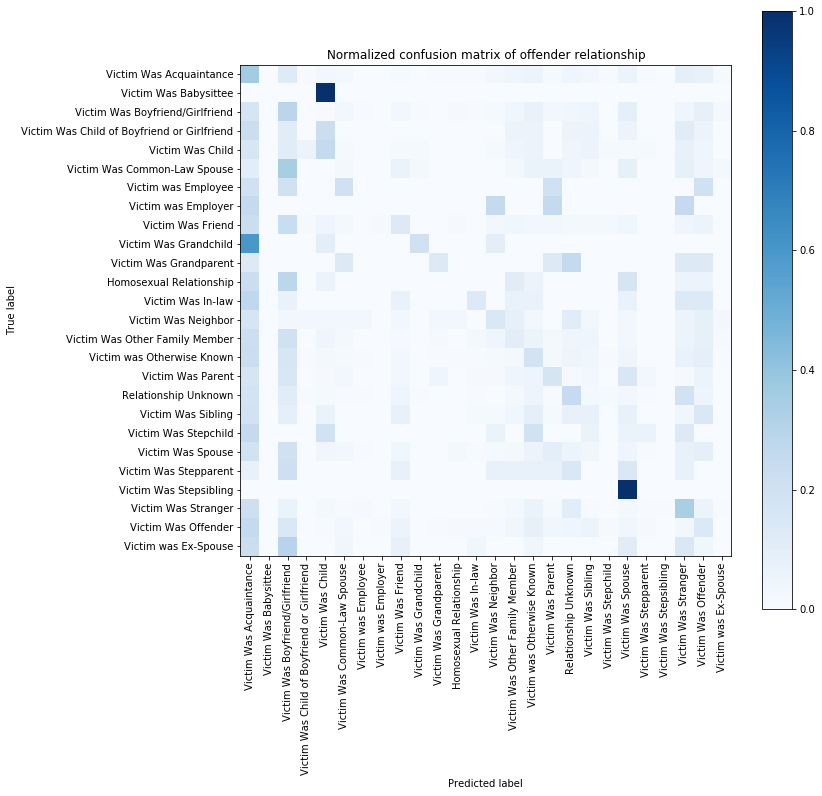

In [196]:
# Plot normalized confusion matrix in relationship
plt.figure(figsize=(11,11))
plot_confusion_matrix(confusion_matrix_relationship, classes=relationship_list, normalize=True,
                      title='Normalized confusion matrix of offender relationship', featureName='relationship')

plt.show()

Normalized confusion matrix of sex


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


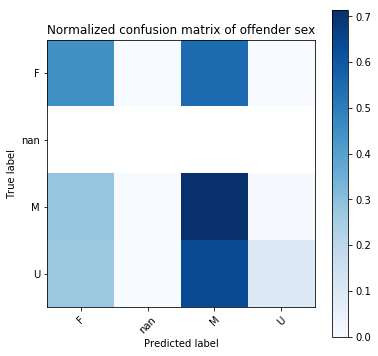

In [184]:
# Plot normalized confusion matrix in sex
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix_sex, classes=sex_list, normalize=True,
                      title='Normalized confusion matrix of offender sex', featureName='sex')

plt.show()

Normalized confusion matrix of race


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


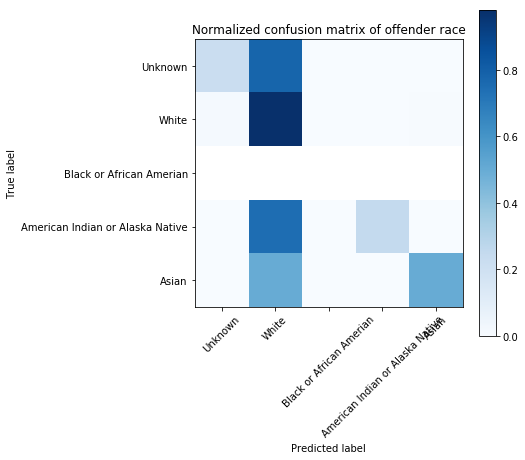

In [193]:
# Plot normalized confusion matrix in race
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix_race, classes=race_list, normalize=True,
                      title='Normalized confusion matrix of offender race', featureName = 'race')

plt.show()

Normalized confusion matrix of ethnicity


/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/xiaoyuq/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


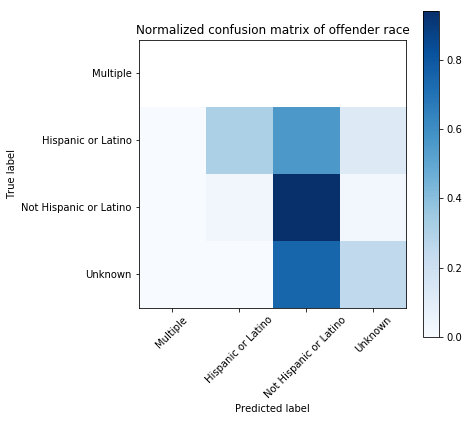

In [194]:
# Plot normalized confusion matrix in ethnicity
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix_ethnicity, classes=ethnicity_list, normalize=True,
                      title='Normalized confusion matrix of offender race', featureName = 'ethnicity')

plt.show()